## Introduction

## Imports and setup

In [317]:
# Imports
import pandas as pd
import numpy as np
from functools import wraps, partial
from itertools import combinations
import time
from matplotlib.offsetbox import AnchoredText
from typing import Literal, Optional, Callable
import re
import missingno as msno
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats.contingency import association
from scipy.spatial.distance import pdist
from ydata_profiling import ProfileReport

In [271]:
converters = {
    'OSEBuildingID': str,
    'YearsENERGYSTARCertified':str,
    }
building_energy_benchmarking = pd.read_csv("2016_Building_Energy_Benchmarking.csv", converters=converters)

In [272]:
# time decorator to quickly measure efficiency of functions
def timeit(func):
    @wraps(func)
    def timeit_wrapper(*args, **kwargs):
        start_time = time.perf_counter()
        result = func(*args, **kwargs)
        end_time = time.perf_counter()
        total_time = end_time - start_time
        print(f'Execution of function {func.__name__} took {total_time:.4f} seconds')
        return result
    return timeit_wrapper

## Data exploration

In [273]:
# Generate general / basic exploration report automatically
# profile = ProfileReport(building_energy_benchmarking, title="Profiling Report")
# profile.to_file(os.path.join("utils", "output_complete.html"))

In [274]:
building_energy_benchmarking.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3376 entries, 0 to 3375
Data columns (total 46 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   OSEBuildingID                    3376 non-null   object 
 1   DataYear                         3376 non-null   int64  
 2   BuildingType                     3376 non-null   object 
 3   PrimaryPropertyType              3376 non-null   object 
 4   PropertyName                     3376 non-null   object 
 5   Address                          3376 non-null   object 
 6   City                             3376 non-null   object 
 7   State                            3376 non-null   object 
 8   ZipCode                          3360 non-null   float64
 9   TaxParcelIdentificationNumber    3376 non-null   object 
 10  CouncilDistrictCode              3376 non-null   int64  
 11  Neighborhood                     3376 non-null   object 
 12  Latitude            

<Axes: >

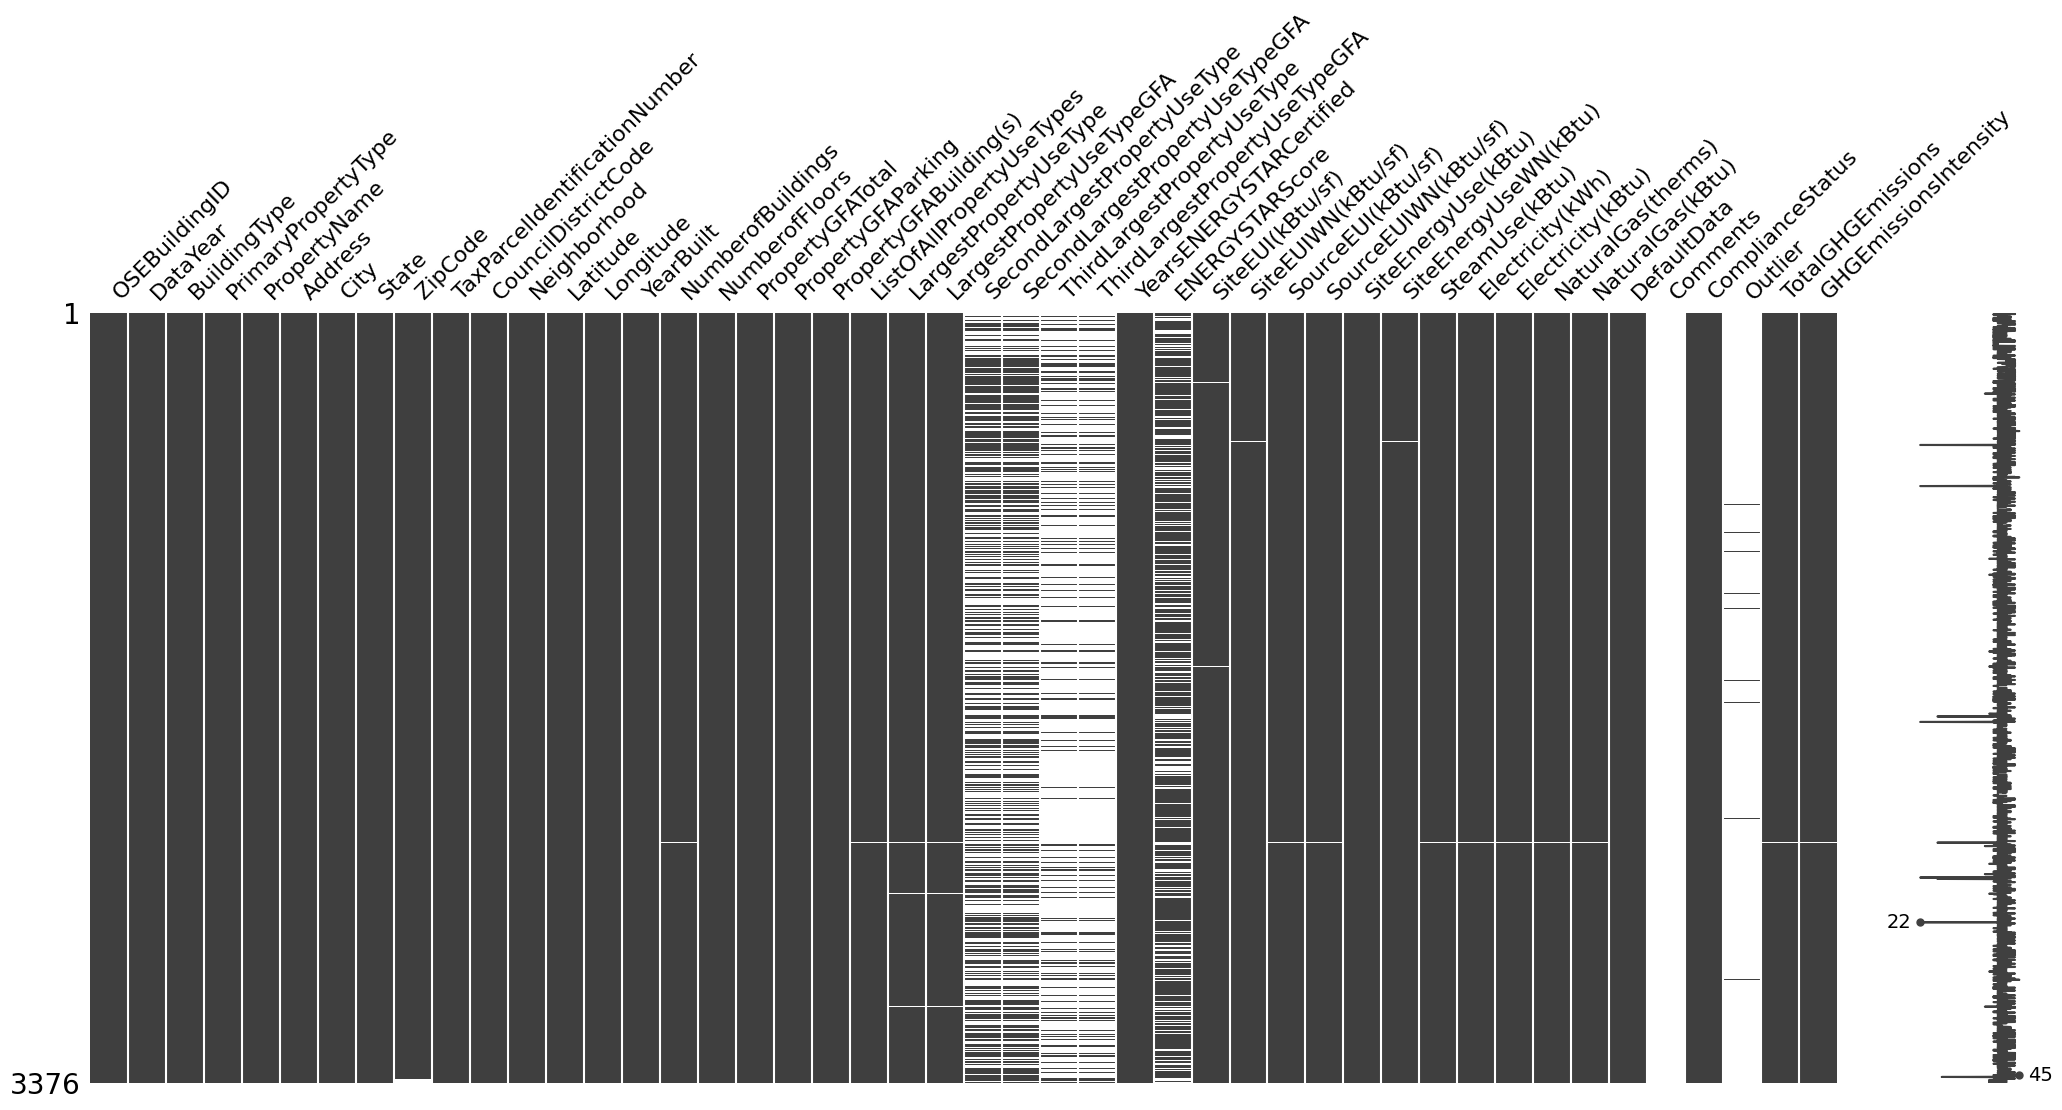

In [275]:
msno.matrix(building_energy_benchmarking)

<Axes: >

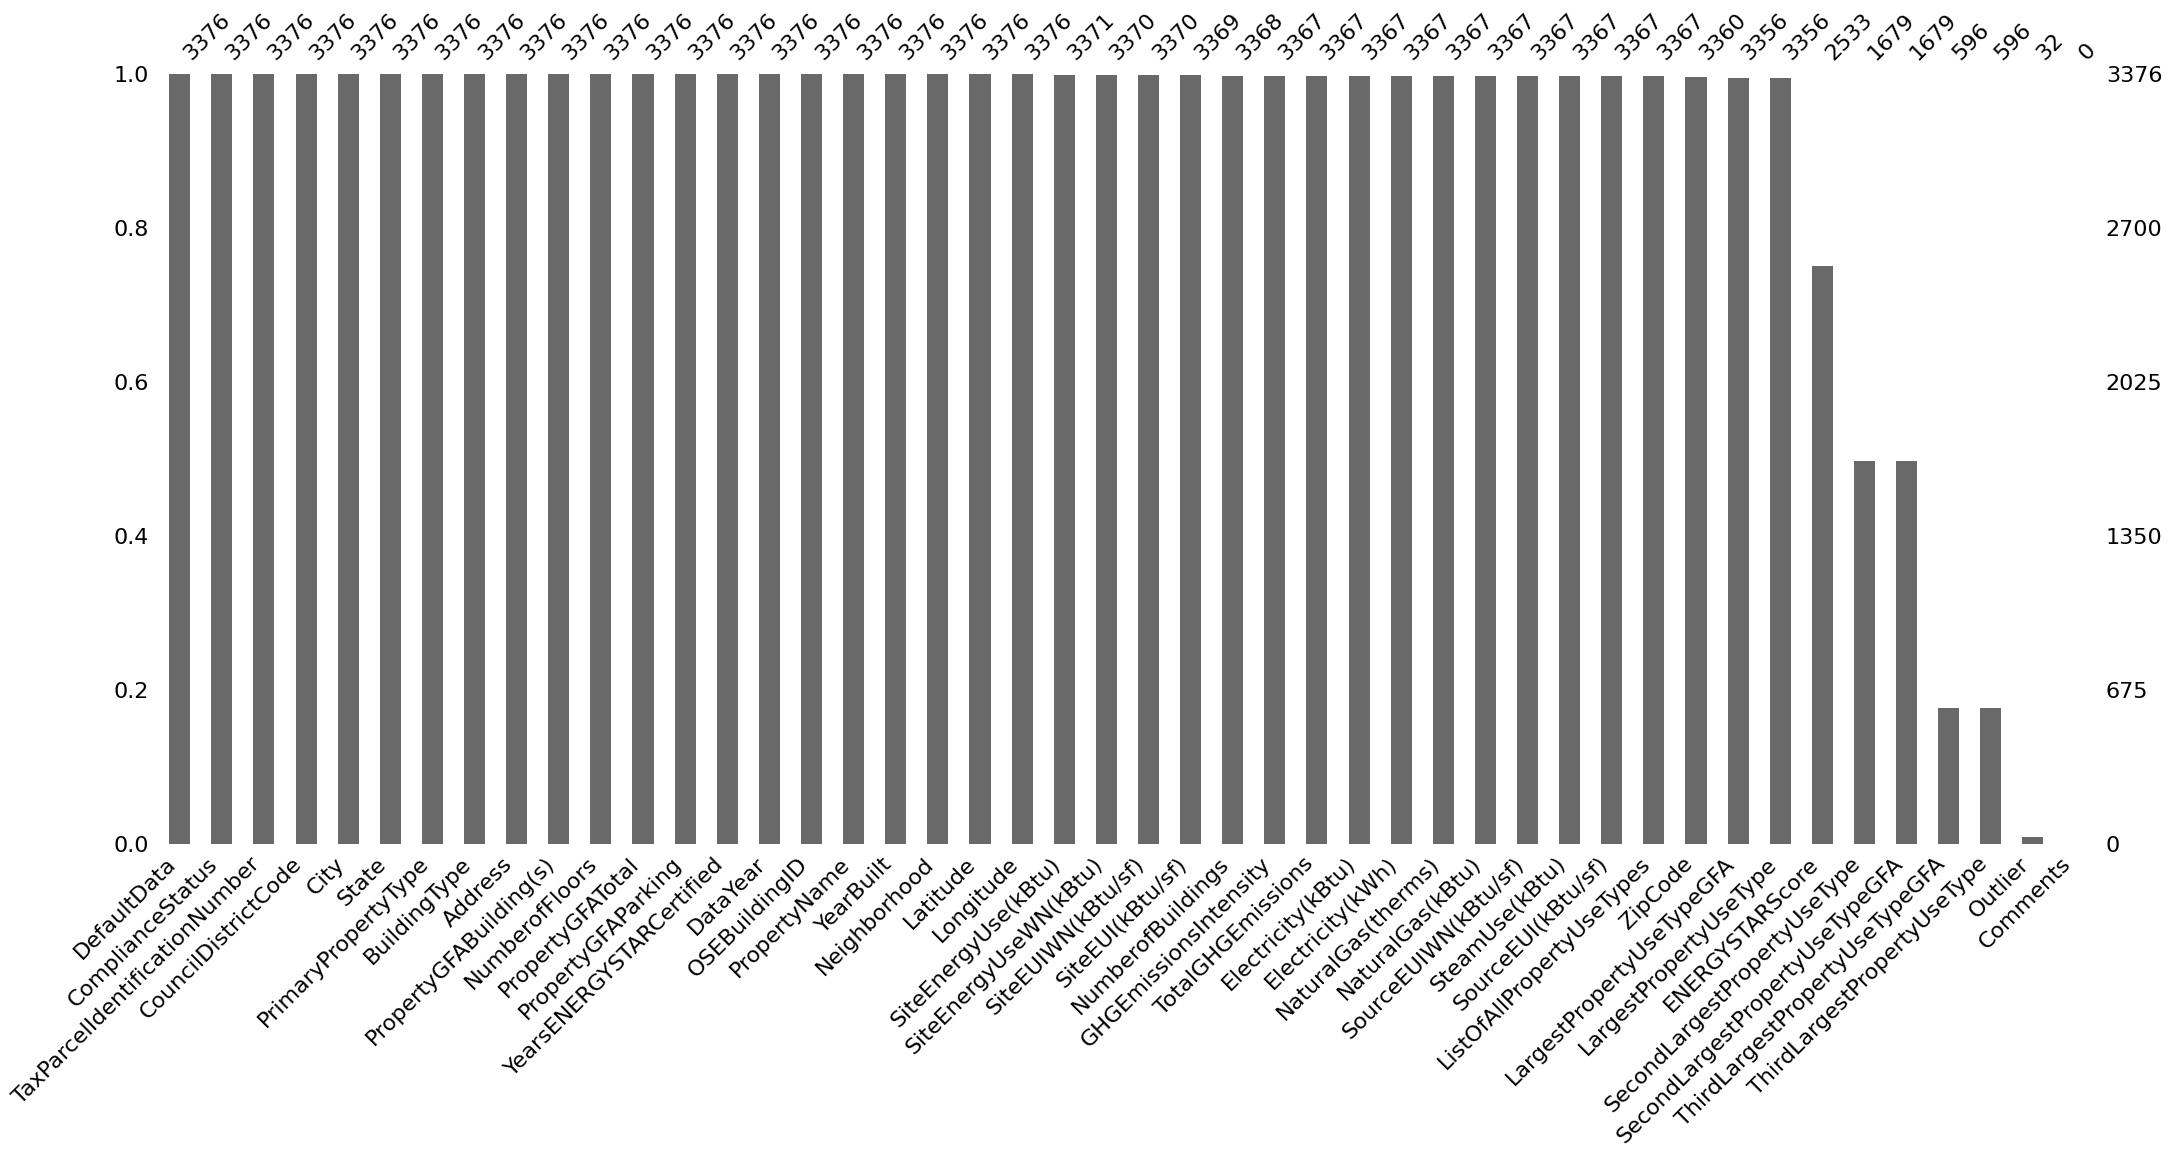

In [276]:
msno.bar(building_energy_benchmarking, sort="descending")

In [277]:
building_energy_benchmarking.describe()

,DataYear,ZipCode,CouncilDistrictCode,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,...,SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),Comments,TotalGHGEmissions,GHGEmissionsIntensity
count,3376.0,3360.000000,3376.000000,3376.000000,3376.000000,3376.000000,3368.000000,3376.000000,3.376000e+03,3376.000000,...,3.371000e+03,3.370000e+03,3.367000e+03,3.367000e+03,3.367000e+03,3.367000e+03,3.367000e+03,0.0,3367.000000,3367.000000
mean,2016.0,98116.949107,4.439277,47.624033,-122.334795,1968.573164,1.106888,4.709123,9.483354e+04,8001.526066,...,5.403667e+06,5.276726e+06,2.745959e+05,1.086639e+06,3.707612e+06,1.368505e+04,1.368505e+06,NaN,119.723971,1.175916
std,0.0,18.615205,2.120625,0.047758,0.027203,33.088156,2.108402,5.494465,2.188376e+05,32326.723928,...,2.161063e+07,1.593879e+07,3.912173e+06,4.352478e+06,1.485066e+07,6.709781e+04,6.709781e+06,NaN,538.832227,1.821452
min,2016.0,98006.000000,1.000000,47.499170,-122.414250,1900.000000,0.000000,0.000000,1.128500e+04,0.000000,...,0.000000e+00,0.000000e+00,0.000000e+00,-3.382680e+04,-1.154170e+05,0.000000e+00,0.000000e+00,NaN,-0.800000,-0.020000
25%,2016.0,98105.000000,3.000000,47.599860,-122.350662,1948.000000,1.000000,2.000000,2.848700e+04,0.000000,...,9.251286e+05,9.701822e+05,0.000000e+00,1.874229e+05,6.394870e+05,0.000000e+00,0.000000e+00,NaN,9.495000,0.210000
50%,2016.0,98115.000000,4.000000,47.618675,-122.332495,1975.000000,1.000000,4.000000,4.417500e+04,0.000000,...,1.803753e+06,1.904452e+06,0.000000e+00,3.451299e+05,1.177583e+06,3.237538e+03,3.237540e+05,NaN,33.920000,0.610000
75%,2016.0,98122.000000,7.000000,47.657115,-122.319407,1997.000000,1.000000,5.000000,9.099200e+04,0.000000,...,4.222455e+06,4.381429e+06,0.000000e+00,8.293178e+05,2.829632e+06,1.189033e+04,1.189034e+06,NaN,93.940000,1.370000
max,2016.0,98272.000000,7.000000,47.733870,-122.220966,2015.000000,111.000000,99.000000,9.320156e+06,512608.000000,...,8.739237e+08,4.716139e+08,1.349435e+08,1.925775e+08,6.570744e+08,2.979090e+06,2.979090e+08,NaN,16870.980000,34.090000


### Reducing the dataset dimensionality

In [278]:
building_energy_benchmarking.shape

(3376, 46)

__Removing residential properties__

In [279]:
def pie_distribution(df:pd.DataFrame, col:str, min_percent:float=3):
  data = df[col].copy()
  value_counts = data.value_counts()
  significant_values = value_counts[value_counts >= min_percent/100*value_counts.sum()]
  other_count = value_counts[value_counts < min_percent/100*value_counts.sum()].sum()
  value_counts_with_others = pd.concat([significant_values, pd.Series({'Other': other_count})])
  fig, ax = plt.subplots(figsize=(3,3))
  ax.pie(value_counts_with_others.values, labels=value_counts_with_others.index, autopct='%1.1f%%', colors=sns.color_palette("pastel"))
  ax.set_title(f"Distribution of '{col}'")


In [280]:
def bar_distribution(df:pd.DataFrame, col:str, figsize:tuple=(5,5), **barlabels_params):
    fig, ax = plt.subplots(figsize=figsize)
    sns.barplot(data=df[col].value_counts(), orient='h', ax=ax)
    for c in ax.containers:
      labels = [int(v.get_width()) if int(v.get_width()) > 0 else '' for v in c]
      # remove the labels parameter if it's not needed for customized labels
      ax.bar_label(c, labels=labels, **barlabels_params)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xlabel("Count")
    ax.set_title(f"Distribution of '{col}'")
    fig.tight_layout()

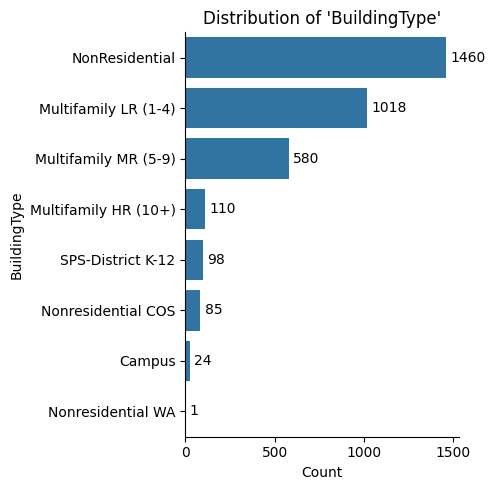

In [281]:
bar_distribution(df=building_energy_benchmarking, col="BuildingType", label_type='edge', padding=3)

In [282]:
# Only keep non residential buildings
relevant_building_types = ["NonResidential", "Nonresidential COS", "SPS-District K-12", "Campus", "Nonresidential WA"] # SPS-District K-12 describes Seattle Public Schools
building_energy_benchmarking = building_energy_benchmarking.loc[building_energy_benchmarking["BuildingType"].isin(relevant_building_types)]
building_energy_benchmarking.shape

(1668, 46)

__Removing non-compliant properties__

Let's try to understand the meaning of columns "ComplianceStatus", "Outlier" and "DefaultData".

Outlier:

*"*[High and low outliers by EUI] *were defined as the highest and lowest 3% of multifamily buildings by EUI and highest and lowest 5% of office buildings by EUI."*<sup>[2](#sources)</sup>

Here we are only interested in the part about office buildings since we only consider non-residential buildings.

In [283]:
def boxplots_with_outliers(df:pd.DataFrame, cols:list, outlier_condition:Optional[pd.Series]=None, title:str="Boxplots"):
  fig, axes = plt.subplots(1, len(cols), figsize=(2*len(cols),5))
  if len(cols) > 1:
    for col, ax in zip(cols, axes):
      sns.boxplot(data=df, y=col, ax=ax)
      if outlier_condition is not None:
        sns.stripplot(data=df.loc[outlier_condition], y=col, ax=ax, jitter=False, color='r')
  else:
    sns.boxplot(data=df, y=cols[0], ax=axes)
    if outlier_condition is not None:
      sns.stripplot(data=df.loc[outlier_condition], y=cols[0], ax=axes, jitter=False, color='r')
  fig.suptitle(title)
  fig.tight_layout()

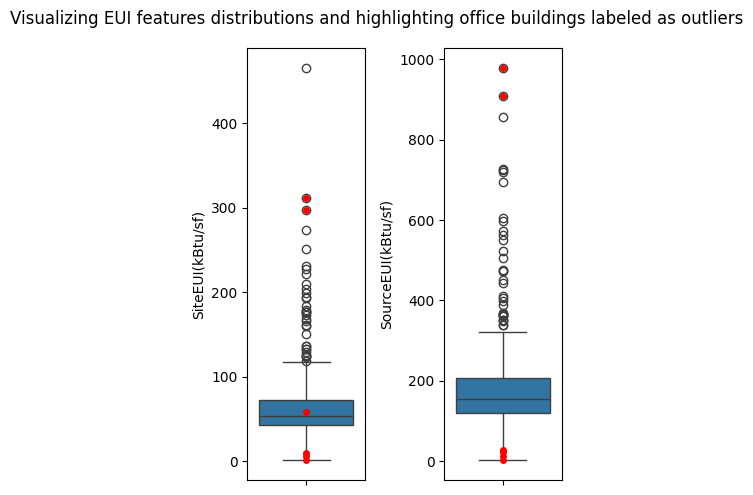

In [284]:
cols = ["SiteEUI(kBtu/sf)", "SourceEUI(kBtu/sf)"]
title = "Visualizing EUI features distributions and highlighting office buildings labeled as outliers"
boxplots_with_outliers(df=building_energy_benchmarking.loc[building_energy_benchmarking["PrimaryPropertyType"].dropna().str.contains("Office")], cols=cols, outlier_condition=building_energy_benchmarking["Outlier"].notna(), title=title)

It seems that feature "Outlier" describes properties with the highest and lowest value of 'SourceEUI'.  
This seems quite arbitrary, and therefore the information brought by feature 'Outlier' will not be used.

ComplianceStatus:

*"Whether a property met energy benchmarking requirements for the specified reporting year, as of the end of that reporting year's enforcement grace period."*<sup>[1](#sources)</sup>

In [285]:
building_energy_benchmarking[["ComplianceStatus", "DefaultData"]].value_counts(dropna=False)

ComplianceStatus              DefaultData
Compliant                     False          1548
Error - Correct Default Data  True             88
Non-Compliant                 False            18
Missing Data                  False            14
Name: count, dtype: int64

Feature 'DefaultData' gives the same information as option 'Error - Correct Default Data' of feature 'ComplianceStatus'.  
Feature 'DefaultData' can be removed.

In [286]:
building_energy_benchmarking.drop(columns="DefaultData", inplace=True)
building_energy_benchmarking.shape

(1668, 45)

Properties not meeting benchmarking requirements (ComplianceStatus = 'Non-Compliant', 'Error - Correct Default Data', 'Missing Data') should be removed. Default data is considered inaccurate here and will be removed as well. Missing Data is assumed to indicate that some information is missing about energy consumption, so these propreties will be removed as well.

In [287]:
# Note that all properties labeled as 'outlier' will actually be removed anyway because they are all considered either 
# 'Non-Compliant' or 'DefaultData'.
building_energy_benchmarking[["ComplianceStatus", "Outlier"]].value_counts(dropna=False)

ComplianceStatus              Outlier     
Compliant                     NaN             1548
Error - Correct Default Data  NaN               86
Missing Data                  NaN               14
Non-Compliant                 Low outlier       13
                              NaN                3
Error - Correct Default Data  Low outlier        2
Non-Compliant                 High outlier       2
Name: count, dtype: int64

In [288]:
building_energy_benchmarking = building_energy_benchmarking.loc[building_energy_benchmarking["ComplianceStatus"] == "Compliant"]
building_energy_benchmarking.shape

(1548, 45)

In [289]:
building_energy_benchmarking.drop(columns=["ComplianceStatus", "Outlier"], inplace=True)
building_energy_benchmarking.shape

(1548, 43)

__Removing duplicated buildings__

In [290]:
looking_for_duplicates = building_energy_benchmarking.loc[building_energy_benchmarking["Address"].duplicated(keep=False)].sort_values("Address")

In [291]:
looking_for_duplicates = building_energy_benchmarking.loc[building_energy_benchmarking["PropertyName"].duplicated(keep=False)].sort_values("PropertyName")

After looking for duplicates through features like 'Address' and 'PropertyName', some of the properties do seem similar, but it is hard to say if those are duplicates or not. No property will be considered as a duplicate for the rest of this project.

__Removing empty columns__

In [292]:
# Remove empty columns
removed_columns = building_energy_benchmarking.loc[:, building_energy_benchmarking.isna().all()].columns
building_energy_benchmarking.dropna(axis=1, how="all", inplace=True)
print(f"""{len(removed_columns)} columns were removed:\n{"\n".join(removed_columns)}""")

1 columns were removed:
Comments


__Removing columns with only 1 unique value__

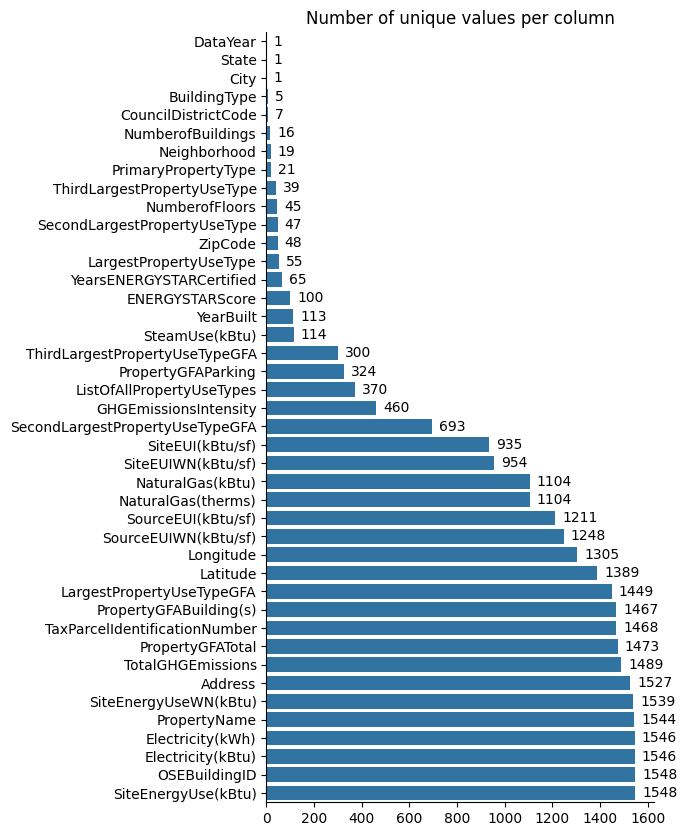

In [293]:
fig, ax = plt.subplots(figsize=(5,10))
unique_values_count = building_energy_benchmarking.apply(lambda s: len(s.dropna().unique()))
sns.barplot(data=unique_values_count, ax=ax, orient='h', order=unique_values_count.sort_values(ascending=True).index)
ax.spines[['right', 'top']].set_visible(False)
ax.set_title("Number of unique values per column")
for i in range(len(ax.containers)):
  ax.bar_label(ax.containers[i], padding=5)

Every single building is located in Seattle in the state of Washington, and data is from 2016.  
Columns "DataYear", "State" and "City" can be removed.

In [294]:
building_energy_benchmarking.drop(["DataYear", "State", "City"], axis=1, inplace=True)
building_energy_benchmarking.shape

(1548, 39)

__Removing highly correalted features__

In [295]:
def draw_heatmap(corr_matrix:pd.DataFrame, **plot_params):
    '''
    Draws a heatmap for the given correlation matrix.

    Parameters:
    corr_matrix (pd.DataFrame): Correlation matrix to visualize.
    '''
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
    fig, ax = plt.subplots(figsize=(15, 10))
    ax = sns.heatmap(corr_matrix, ax=ax, mask=mask, center=0, **plot_params)
    ax.set_title("Correlation matrix", size=16)
    plt.plot()


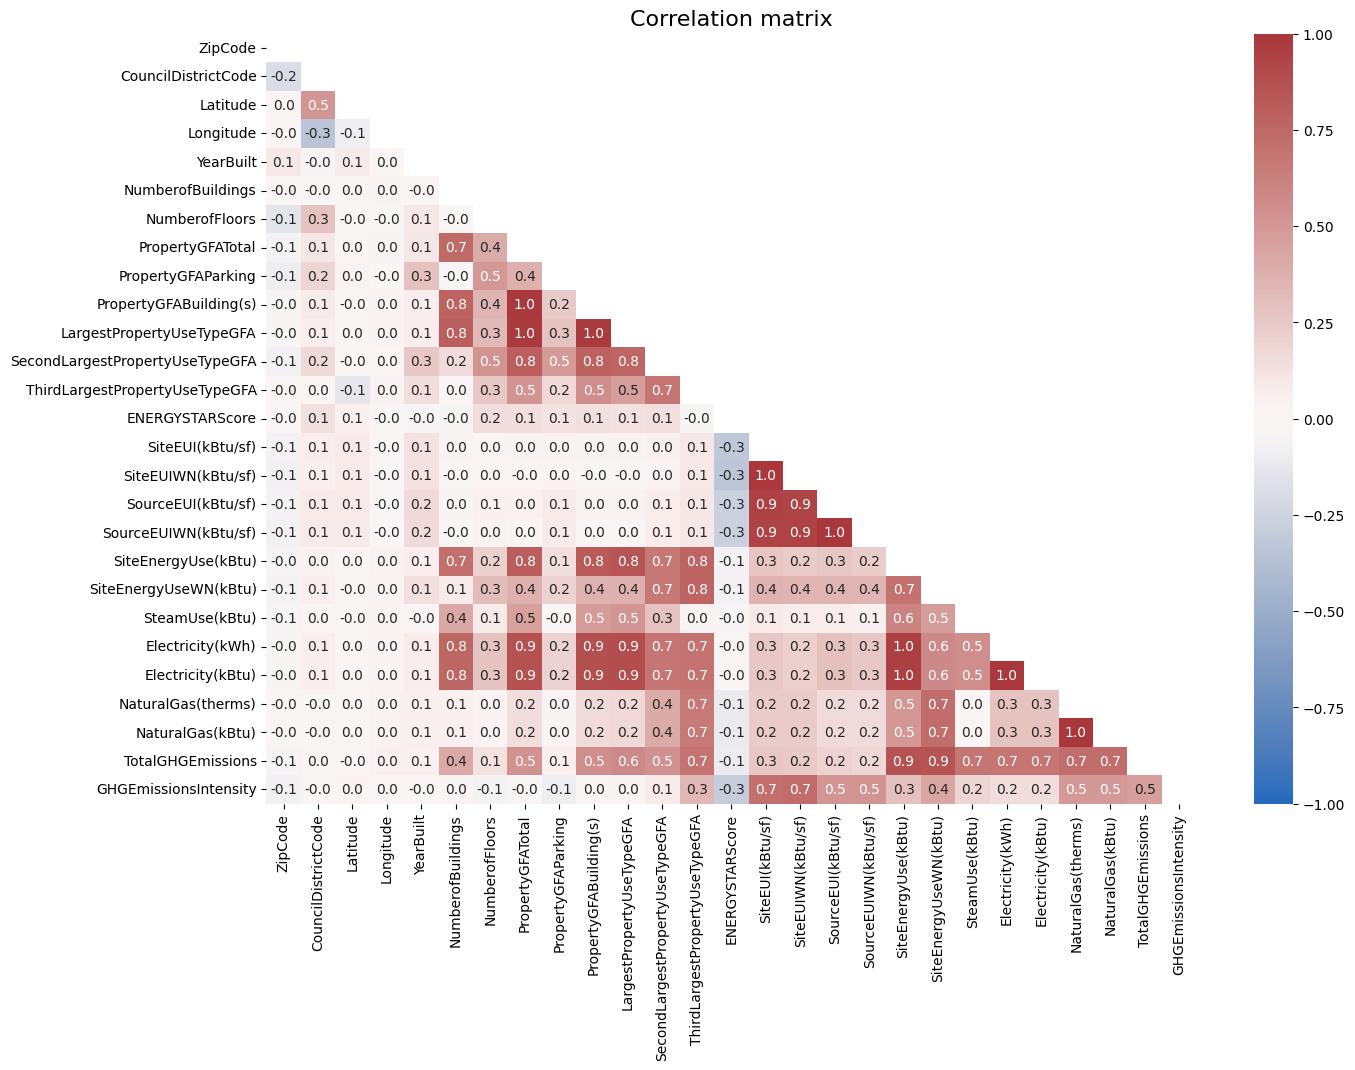

In [455]:
draw_heatmap(building_energy_benchmarking.corr(numeric_only=True, min_periods=100), vmin=-1, vmax=1, annot=True, fmt=".1f", cmap='vlag')

In [319]:
def remove_outliers(s: pd.Series) -> pd.Series:
    '''
    Removes outliers from a Series based on the IQR method.

    Parameters:
    s (pd.Series): Series from which to remove outliers.

    Returns:
    pd.Series: Series with outliers replaced by NaN.
    '''
    s_copy = s.copy()
    
    q1 = s_copy.quantile(0.25)
    q3 = s_copy.quantile(0.75)
    iqr = q3 - q1

    # Define the bounds for outliers
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    
    # Remove rows with outliers
    s_copy.loc[(s_copy < lower_bound) | (s_copy > upper_bound)] = np.nan

    return s_copy

In [320]:
# Apply a list of functions to transform the data
def transform_data(df:pd.DataFrame, funcs:list[Callable]) -> pd.DataFrame:
    '''
    Applies a list of functions to transform the DataFrame.

    Parameters:
    df (pd.DataFrame): DataFrame to transform.
    funcs (list[Callable]): List of functions to apply to the DataFrame.

    Returns:
    pd.DataFrame: Transformed DataFrame.
    '''
    df_copy = df.copy()
    if funcs is not None and len(funcs) > 0:
        for f in funcs:
            try:
                # Iterate over numeric columns
                for col in df_copy.select_dtypes(include=[np.number]).columns:
                    df_copy[col] = f(df_copy[col])
            except AttributeError:
                df_copy = f(df_copy)

    return df_copy

In [411]:
def draw_correlation_plot(df:pd.DataFrame, x:str, y:str, transforms:list[Callable]=[remove_outliers], outliers_condition:pd.Series=None, title:str=None):
    fig, ax = plt.subplots(figsize=(10,4))
    transformed_df = transform_data(df, funcs=transforms)
    corr = transformed_df[x].corr(transformed_df[y], method='pearson', min_periods=100)
    sns.regplot(data=transformed_df, x=x, y=y, ci=None, ax=ax)
    if outliers_condition is not None:
      sns.scatterplot(data=transformed_df.loc[outliers_condition], x=x, y=y, ax=ax, color='red')
    corr_coef = AnchoredText(f"R² = {round(corr**2, 2)}", loc="upper left")
    ax.add_artist(corr_coef)
    if title is None:
       title=f"Illustration of linear correlation between {x} and {y}"
    ax.set_title(title)

Coefficients for SourceEUI should be<sup>[3](#sources)</sup>:
- Electricity from the grid : 2.8
- Natural Gas : 1.05
- Steam : 1.2

In [ ]:
building_energy_benchmarking["LargestPropertyUseTypeGFA"]

In [453]:
interesting_features = ["Electricity(kBtu)", "SteamUse(kBtu)", "NaturalGas(kBtu)", "SiteEnergyUse(kBtu)", "SiteEnergyUseWN(kBtu)", "PropertyGFATotal", "PropertyGFABuilding(s)", "PropertyGFAParking", "LargestPropertyUseTypeGFA", "SecondLargestPropertyUseTypeGFA", "ThirdLargestPropertyUseTypeGFA", "SiteEUI(kBtu/sf)", "SourceEUI(kBtu/sf)"]
test = building_energy_benchmarking[interesting_features]
test["CustomPropertyGFATotal"] = test["PropertyGFABuilding(s)"] + test["PropertyGFAParking"]
test["CustomSiteEnergyUse(kBtu)"] = test["Electricity(kBtu)"] + test["SteamUse(kBtu)"] + test["NaturalGas(kBtu)"] 
test["CustomSiteEUI(kBtu/sf)"] = test["SiteEnergyUse(kBtu)"] / test["PropertyGFABuilding(s)"] # test["PropertyGFATotal"]
test["CustomSourceEUI(kBtu/sf)"] = (3.14*test["Electricity(kBtu)"] + 1.2*test["SteamUse(kBtu)"] + 1.05*test["NaturalGas(kBtu)"])/ test["PropertyGFABuilding(s)"] 
test["CustomSourceEnergyUse(kBtu)"] = test["SourceEUI(kBtu/sf)"] *  test["PropertyGFABuilding(s)"]

C:\Users\HCYF5290\AppData\Local\Temp\ipykernel_20012\1410813699.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test["CustomPropertyGFATotal"] = test["PropertyGFABuilding(s)"] + test["PropertyGFAParking"]
C:\Users\HCYF5290\AppData\Local\Temp\ipykernel_20012\1410813699.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test["CustomSiteEnergyUse(kBtu)"] = test["Electricity(kBtu)"] + test["SteamUse(kBtu)"] + test["NaturalGas(kBtu)"]
C:\Users\HCYF5290\AppData\Local\Temp\ipykernel_20012\1410813699.py:5: Set

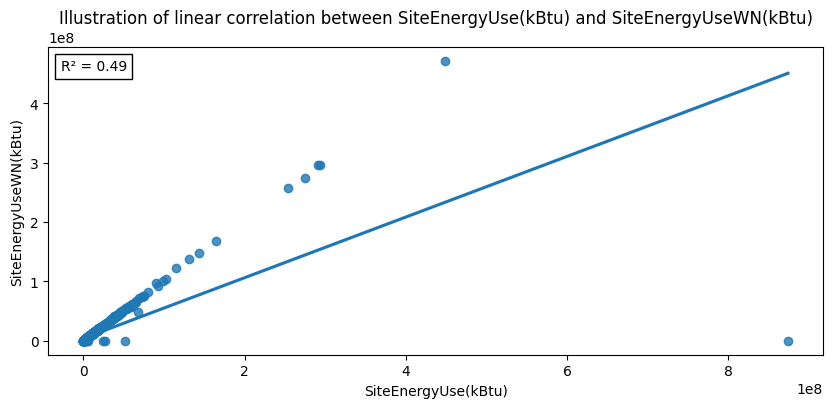

In [456]:
draw_correlation_plot(test, x="SiteEnergyUse(kBtu)", y="SiteEnergyUseWN(kBtu)", transforms=[])

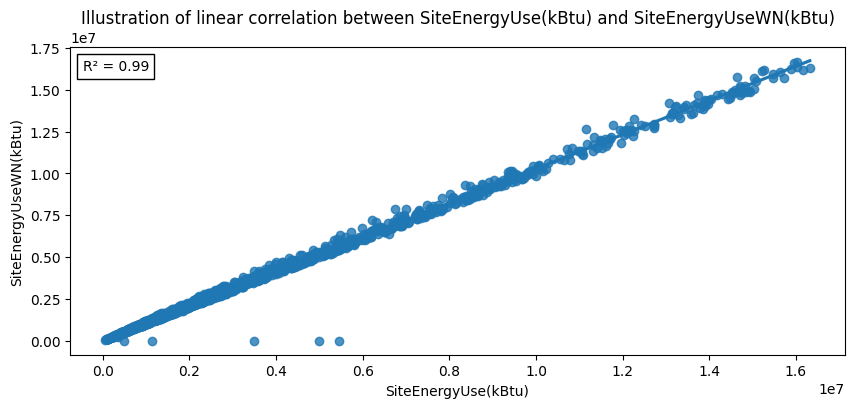

In [454]:
draw_correlation_plot(test, x="SiteEnergyUse(kBtu)", y="SiteEnergyUseWN(kBtu)")

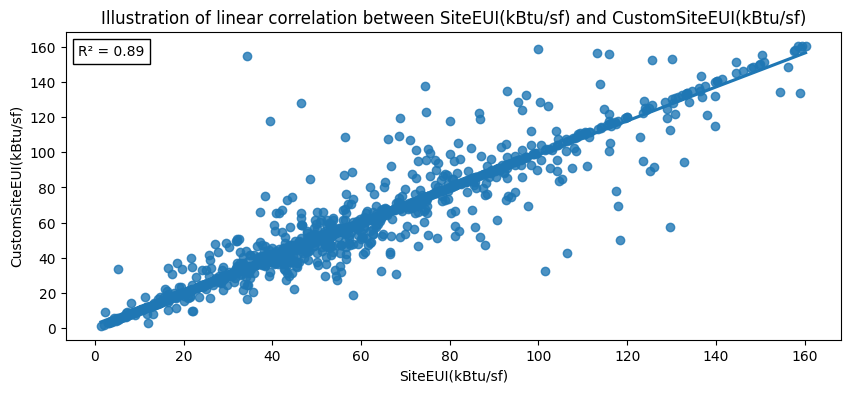

In [445]:
draw_correlation_plot(test, x="SiteEUI(kBtu/sf)", y="CustomSiteEUI(kBtu/sf)")

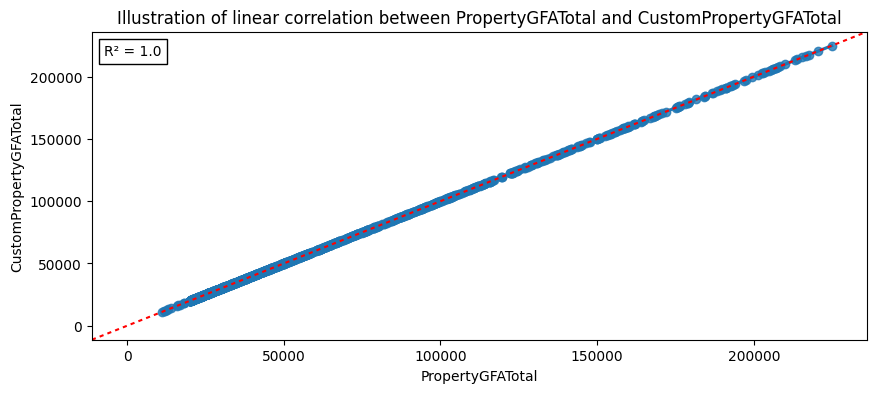

In [437]:
draw_correlation_plot(test, x="PropertyGFATotal", y="CustomPropertyGFATotal")
plt.axline((0, 0), slope=1, color='r', dashes=[2,2,2,2])

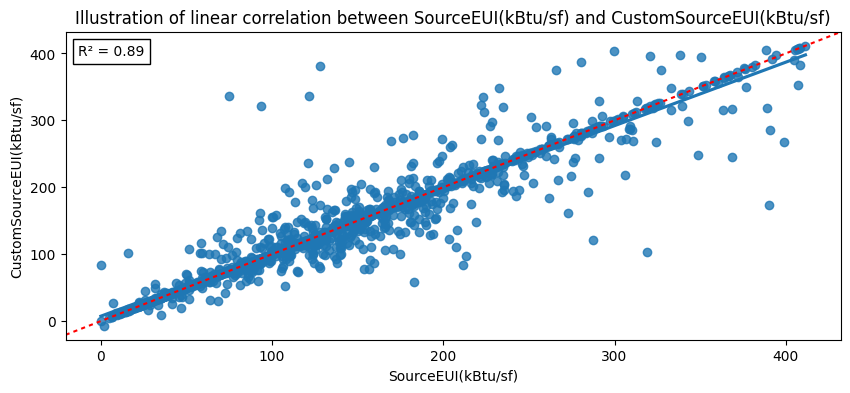

In [449]:
draw_correlation_plot(test, x="SourceEUI(kBtu/sf)", y="CustomSourceEUI(kBtu/sf)")
plt.axline((0, 0), slope=1, color='r', dashes=[2,2,2,2])

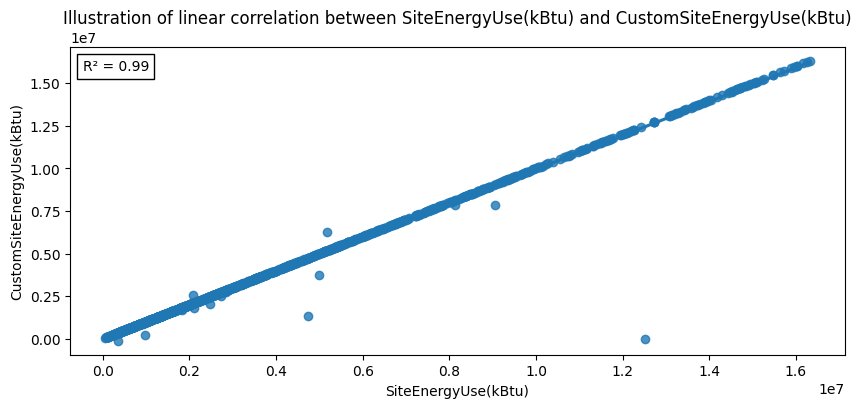

In [439]:
draw_correlation_plot(test, x="SiteEnergyUse(kBtu)", y="CustomSiteEnergyUse(kBtu)")

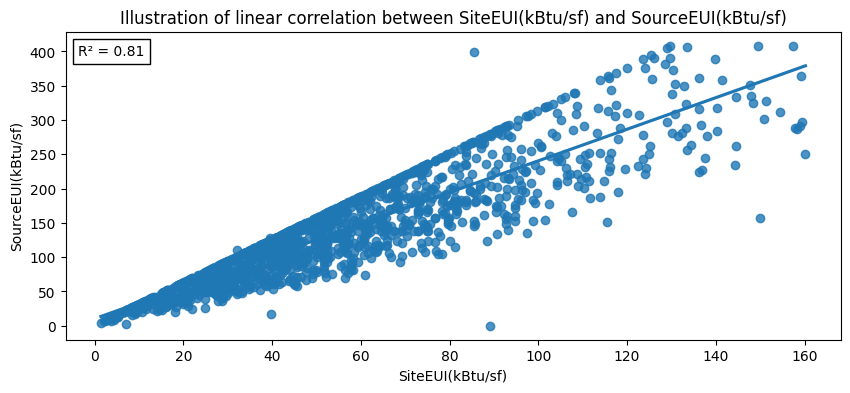

In [440]:
draw_correlation_plot(test, x="SiteEUI(kBtu/sf)", y="SourceEUI(kBtu/sf)")

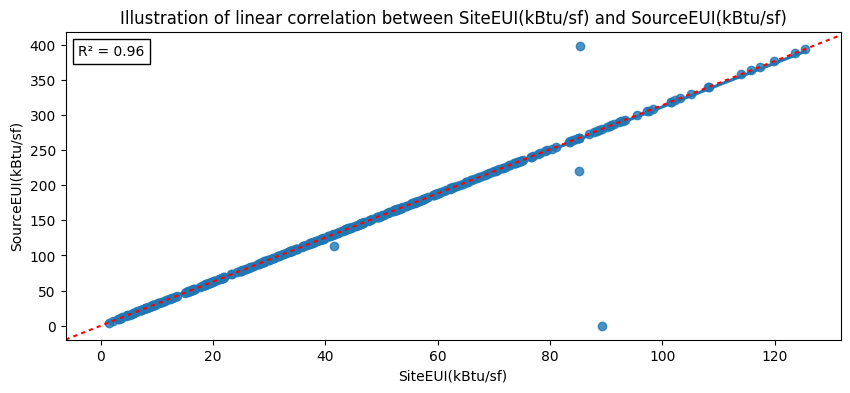

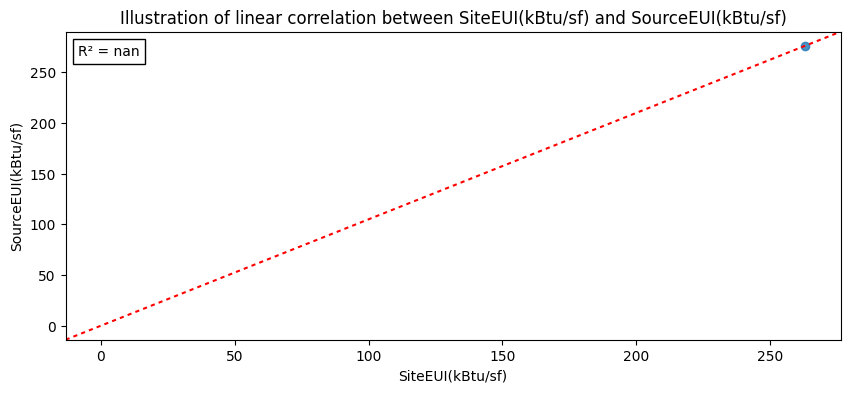

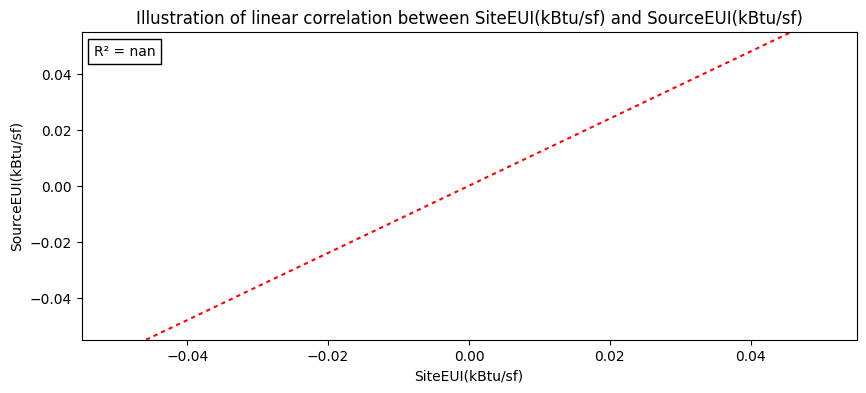

In [ ]:
only_electricity = test.loc[(test["Electricity(kBtu)"] > 0) & (test["NaturalGas(kBtu)"] == 0) & (test["SteamUse(kBtu)"] == 0)]
title="Illustration of linear correlation between SiteEUI(kBtu/sf) and {y}"
draw_correlation_plot(only_electricity, x="SiteEUI(kBtu/sf)", y="SourceEUI(kBtu/sf)")
plt.axline((0, 0), slope=3.14, color='r', dashes=[2,2,2,2])
only_gas = test.loc[(test["Electricity(kBtu)"] == 0) & (test["NaturalGas(kBtu)"] > 0) & (test["SteamUse(kBtu)"] == 0)]
draw_correlation_plot(only_gas, x="SiteEUI(kBtu/sf)", y="SourceEUI(kBtu/sf)")
plt.axline((0, 0), slope=1.05, color='r', dashes=[2,2,2,2])
only_steam = test.loc[(test["Electricity(kBtu)"] == 0) & (test["NaturalGas(kBtu)"] == 0) & (test["SteamUse(kBtu)"] > 0)]
draw_correlation_plot(only_steam, x="SiteEUI(kBtu/sf)", y="SourceEUI(kBtu/sf)")
plt.axline((0, 0), slope=1.2, color='r', dashes=[2,2,2,2])

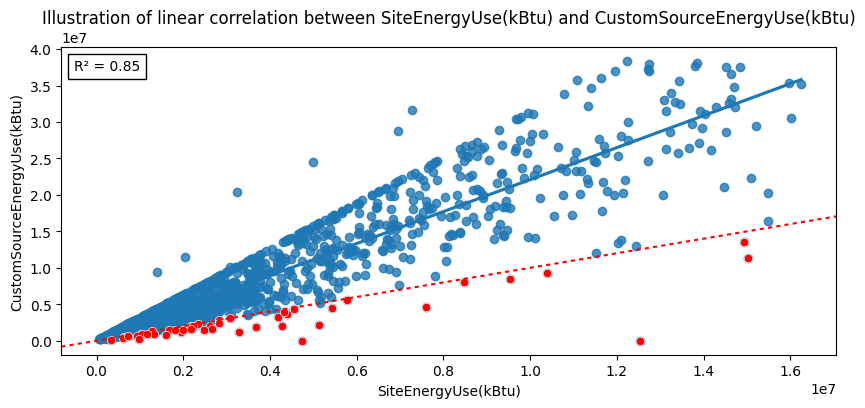

In [423]:
draw_correlation_plot(test, x="SiteEnergyUse(kBtu)", y="CustomSourceEnergyUse(kBtu)", outliers_condition=test["SiteEnergyUse(kBtu)"]>test["CustomSourceEnergyUse(kBtu)"])
plt.axline((0, 0), slope=1, color='r', dashes=[2,2,2,2])

From this correlation matrix, we can already see some interesting relations:

- The size of the property seems highly correlated with the energy consumption.
- The property total GFA is extremely correlated with the property buildings GFA.
- Energy in different units is obviously extremely correlated.

Unit kBTU means one-thousand British thermal units, a common unit of energy measurement used to convert and combine other energy measurements such as kilowatt-hours (kWh) of electricity, therms of natural gas, and pounds of steam.

To be able to compare the energy consumption of different sources, only unit kBtu will be kept.

In [ ]:
building_energy_benchmarking.drop(columns=["Electricity(kWh)", "NaturalGas(therms)"])

State / City / CouncilDistrictCode / ZipCode / Neighborhood / TaxParcelIdentificationNumber / Address / Latitude + Longitude -> That's a lot of features to define the location of the property. It should be possible to remove or combine some of them.

Based on the definition of the columns, some of them seem really similar and could be combined or removed:

- PropertyGFATotal / PropertyGFABuildings / PropertyGFAParking -> PropertyGFATotal / PropertyGFARatio ?
- SourceEUIWN(kBtu/sf) / SourceEUI(kBtu/sf) -> Weather normalized data is not necessary
- SiteEUIWN(kBtu/sf) / SiteEUI(kBtu/sf) / SiteEnergyUse(kBtu) / SiteEnergyUseWN(kBtu) -> Weather normalized data is not necessary and not necessary to have "Energy Use" and "Energy Use Intensity".
- ListOfAllPropertyUseTypes / LargestPropertyUseType / SecondLargestPropertyUseType / ThirdLargestPropertyUseType -> Maybe not necessary to have the third largest, less than 1/6 properties have one. Is it necessary to keep "ListOfAllPropertyUseTypes" ?
- LargestPropertyUseTypeGFA / SecondLargestPropertyUseTypeGFA / ThirdLargestPropertyUseTypeGFA -> If third type is removed we can only keep the 2 first here. Maybe turning it into ratio of PropertyGFATotal would be more relevant ? Not sure about that.
- Electricity(kWh) / Electricity(kBtu) -> Only the unit changes
- NaturalGas(therms) / NaturalGas(kBtu) -> Only the unit changes 
- State / City / CouncilDistrictCode / ZipCode / Neighborhood / TaxParcelIdentificationNumber / Address / Latitude + Longitude -> That's a lot of features to define the location of the property. It should be possible to remove or combine some of them.

### Choosing the targets

Targets are:

- SiteEnergyUse(kBtu)
- TotalGHGEmissions

Columns that should not be included in the model because it would cause data leakage:

- Electricity(kBtu)
- SteamUse(kBtu)
- NaturalGas(kBtu)
- ENERGYSTARScore

However, for all new buildings an initial reference survey will be taken in the first year. We can use this information to get the proportion of each type of energy source or other structural data.

Properties that should not be included in the model:

- Non-Compliant benchmarking requirements (ComplianceStatus = 'Non-Compliant', 'Error - Correct Default Data', 'Missing Data'). Default data is considered inaccurate.
- Residential properties (BuildingType != "NonResidential", "Nonresidential COS", "SPS-District K-12", "Campus", "Nonresidential WA")

In [70]:
def get_crosstab_pair_features(col1:str, col2:str, df:pd.DataFrame, returned_value:Literal['association', 'contingency_table']='contingency_table'):
    '''
    Indicates how related 2 categorical variables are.
    Returns the corresponding normalized contingency table.
    '''
    dropped_df = df.dropna(subset=[col1, col2])
    if (len(dropped_df[col1].unique()) > 0.5*dropped_df.shape[0]) or (len(dropped_df[col2].unique()) > 0.5*dropped_df.shape[0]): # Arbitrarly threshold just to avoid too long execution time
      return np.nan
      # raise Exception("Too many unique values to compute crosstab_result.")

    crosstab_result_normalized = pd.crosstab(index=dropped_df[col1], columns=dropped_df[col2], normalize='index')
    crosstab_result = pd.crosstab(index=dropped_df[col1], columns=dropped_df[col2])
    association_metric = association(crosstab_result)

    if returned_value == "association":
       return association_metric
    
    print("The association variable between",crosstab_result.index.name,"and",crosstab_result.columns.name,"is:",association_metric)
    return crosstab_result_normalized

In [143]:
object_columns = building_energy_benchmarking.select_dtypes(include=[object, bool]).columns

# Create an empty DataFrame
association_table = pd.DataFrame(columns=object_columns, index=object_columns)

# Use combinations to iterate over pairs of columns
for col1, col2 in combinations(object_columns, 2):
    association_table.loc[col1, col2] = get_crosstab_pair_features(col1, col2, df=building_energy_benchmarking, returned_value="association")

c:\Git-OpenClassrooms\DS_4\.venv\Lib\site-packages\scipy\stats\contingency.py:512: RuntimeWarning: invalid value encountered in scalar divide
  value = phi2 / min(n_cols - 1, n_rows - 1)
c:\Git-OpenClassrooms\DS_4\.venv\Lib\site-packages\scipy\stats\contingency.py:512: RuntimeWarning: invalid value encountered in scalar divide
  value = phi2 / min(n_cols - 1, n_rows - 1)
c:\Git-OpenClassrooms\DS_4\.venv\Lib\site-packages\scipy\stats\contingency.py:512: RuntimeWarning: invalid value encountered in scalar divide
  value = phi2 / min(n_cols - 1, n_rows - 1)
c:\Git-OpenClassrooms\DS_4\.venv\Lib\site-packages\scipy\stats\contingency.py:512: RuntimeWarning: invalid value encountered in scalar divide
  value = phi2 / min(n_cols - 1, n_rows - 1)
c:\Git-OpenClassrooms\DS_4\.venv\Lib\site-packages\scipy\stats\contingency.py:512: RuntimeWarning: invalid value encountered in scalar divide
  value = phi2 / min(n_cols - 1, n_rows - 1)
c:\Git-OpenClassrooms\DS_4\.venv\Lib\site-packages\scipy\stats\co

<Axes: >

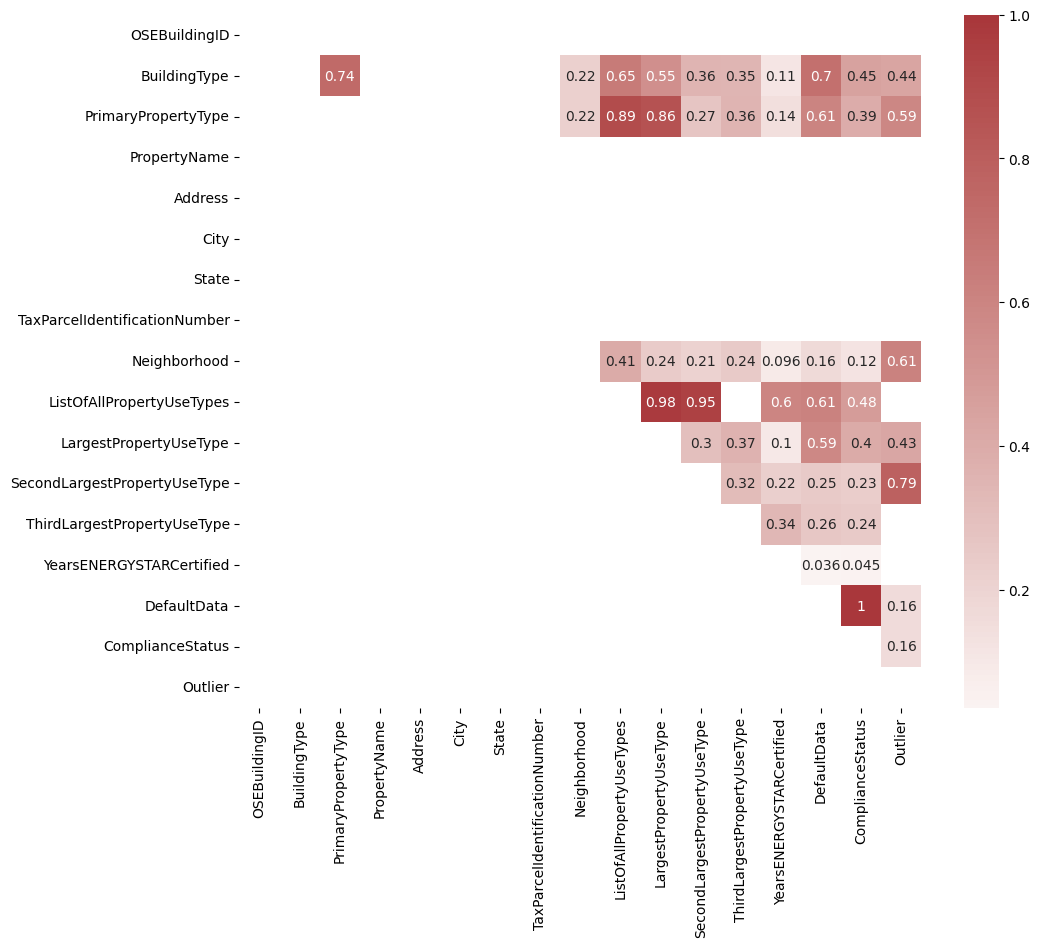

In [451]:
fig, ax = plt.subplots(figsize=(11,9))
sns.heatmap(association_table.astype(float), annot=True, fmt= ".2g", ax=ax, cmap='vlag', center=0)

In [106]:
building_energy_benchmarking["LargestPropertyUseType"].value_counts()

LargestPropertyUseType
Multifamily Housing                                     1667
Office                                                   498
Non-Refrigerated Warehouse                               199
K-12 School                                              139
Other                                                    102
Retail Store                                              99
Hotel                                                     77
Worship Facility                                          71
Distribution Center                                       54
Senior Care Community                                     46
Medical Office                                            41
Supermarket/Grocery Store                                 41
Parking                                                   32
Other - Recreation                                        31
Self-Storage Facility                                     28
College/University                                        25
R

In [ ]:
def remove_non_words_chars(s:str, escape_chars:list=[]):
    ''' 
    Removes non words characters (even whitespaces) and set to lower case.
    Used to detect hidden missing values ('N/A', 'UNKNOWN', ...)
    '''
    if pd.isnull(s):
        return s
    escape_pattern = ''.join(re.escape(char) for char in escape_chars)
    pattern = r'[^\w' + escape_pattern + r']|_'
    return re.sub(pattern, '', str(s), flags=re.UNICODE).lower()

In [ ]:
def find_hidden_missing_values(df:pd.DataFrame, standardize:bool=True, print_result:bool = True, impute_nan:bool=False, additional_hidden_null_values:list[str] = ["unknown", "null", "nan", "na", "0", "inconnu", "unavailable", "not stated"]):   
    df_copy = df.copy()

    for col in df_copy:
        if standardize:
            data = df_copy[col].map(remove_non_words_chars)
        else:
            data = df_copy[col]
        contains_alphanumeric = data.str.contains(pat=r'\w', na=True, regex=True)
        hidden_null_values_condition = ~contains_alphanumeric | data.isin(additional_hidden_null_values)
        
        if hidden_null_values_condition.any():
            if print_result:
                hidden_null_values = df_copy.loc[hidden_null_values_condition, col]
                print(f"""
{hidden_null_values.shape[0]} values in '{col}' can be considered as null values:
{hidden_null_values}
{'*'*30}""")
            if impute_nan:
                df_copy.loc[hidden_null_values_condition, col] = np.nan
    
    if impute_nan:
        return df_copy

In [322]:
building_energy_benchmarking_objects_cols = building_energy_benchmarking.select_dtypes(include=object).columns
building_energy_benchmarking[building_energy_benchmarking_objects_cols] = find_hidden_missing_values(building_energy_benchmarking[building_energy_benchmarking_objects_cols], impute_nan=True)


3257 values in 'YearsENERGYSTARCertified' can be considered as null values:
0        
1        
2        
3        
4        
       ..
3371     
3372     
3373     
3374     
3375     
Name: YearsENERGYSTARCertified, Length: 3257, dtype: object
******************************


In [327]:
LISTLIKE_COLS = ["ListOfAllPropertyUseTypes", "YearsENERGYSTARCertified"]

In [328]:
def all_property_use_types_to_list(s:str):
  if isinstance(s, str):
    return re.split(r',\s*(?![^()]*\))', s)
  return s

In [329]:
def years_energy_star_certified(s:str):
  if isinstance(s, str):
    n=4
    return [s[i:i+n] for i in range(0, len(s), n)]
  return s

In [330]:
# Preprocessing some variables
building_energy_benchmarking["ListOfAllPropertyUseTypes"] = building_energy_benchmarking["ListOfAllPropertyUseTypes"].apply(all_property_use_types_to_list)
building_energy_benchmarking["YearsENERGYSTARCertified"] = building_energy_benchmarking["YearsENERGYSTARCertified"].apply(years_energy_star_certified)
building_energy_benchmarking["Neighborhood"] = building_energy_benchmarking["Neighborhood"].str.lower()
building_energy_benchmarking.loc[building_energy_benchmarking["Neighborhood"] == "delridge neighborhoods", "Neighborhood"] = "delridge"

Here's what to keep in mind after looking at all those graphs:

- Some outliers need further investigation. In the mean type, investigate the meaning of "Outlier" feature.
- Some column names are really similar (SiteEnergyUse and SiteEnergyUseWN for example - WN means Weather Normalized here), those features should be compared. Some of those simlilar features only seem to have different units, so correlations should be checked, of course. 


### Fix dtypes

<a id="sources"></a>
## Sources

[1] [https://data.seattle.gov/Built-Environment/Building-Energy-Benchmarking-Data-2015-Present/teqw-tu6e/about_data](https://data.seattle.gov/Built-Environment/Building-Energy-Benchmarking-Data-2015-Present/teqw-tu6e/about_data)  
[2] [https://www.seattle.gov/documents/Departments/OSE/EBR-2013-report.pdf](https://www.seattle.gov/documents/Departments/OSE/EBR-2013-report.pdf)  
[3] [https://portfoliomanager.energystar.gov/pdf/reference/Source%20Energy.pdf](https://portfoliomanager.energystar.gov/pdf/reference/Source%20Energy.pdf?_gl=1*1j38vqj*_ga*MTE1NjE4MDc0OS4xNzM4OTMwMDgy*_ga_S0KJTVVLQ6*MTc0MDA3MzE4OS40LjEuMTc0MDA3MzY5My4wLjAuMA..)